In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from lmfit import Model

# Multiresponse parameter estimation

The aim of this example (Bates and Watts, 1988, p. 147) is to present how a multiresponse parameter estimation can be performed properly. 

Note that specific adjustments such as:

    i) using different optimization algorithms/methods (lmfit, scipy's L-BFGS-B & Differential Evolution)

    ii) reducing the number of responses

    iii) using different loss functions for convergence

    iv) re-assessing initial values for parameter estimation

might be needed before/after assessing the models in order to attain optimal results.

In [2]:
# create the initial dataframe
df = pd.DataFrame(columns = ["Time (min)", "a-Pinene (%)", "Dipentene (%)", "Allocimene (%)", "Dimer (%)"])

time = np.array([1230, 3060, 4920, 7800, 10680, 15030, 22620, 36420])
df["Time (min)"] = time

a_pinene = np.array([88.35, 76.4, 65.1, 50.4, 37.5, 25.9, 14.0, 4.5])
df['a-Pinene (%)'] = a_pinene

depentene = np.array([7.3, 15.6, 23.1, 32.9, 42.7, 49.1, 57.4, 63.1])
df["Dipentene (%)"] = depentene

allocimene = np.array([2.3, 4.5, 5.3, 6.0, 6.0, 5.9, 5.1, 3.8])
df["Allocimene (%)"] = allocimene

pyronene = np.array([0.4, 0.7, 1.1, 1.5, 1.9, 2.2, 2.6, 2.9])
df["Pyronene (%)"] = pyronene

dimer = np.array([1.75, 2.8, 5.8, 9.3, 12.0, 17.0, 21.0, 25.7])
df['Dimer (%)'] = dimer

In [3]:
df

,Time (min),a-Pinene (%),Dipentene (%),Allocimene (%),Dimer (%),Pyronene (%)
0,1230,88.35,7.3,2.3,1.75,0.4
1,3060,76.40,15.6,4.5,2.80,0.7
2,4920,65.10,23.1,5.3,5.80,1.1
3,7800,50.40,32.9,6.0,9.30,1.5
4,10680,37.50,42.7,6.0,12.00,1.9
5,15030,25.90,49.1,5.9,17.00,2.2
6,22620,14.00,57.4,5.1,21.00,2.6
7,36420,4.50,63.1,3.8,25.70,2.9


In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time (min),a-Pinene (%),Dipentene (%),Allocimene (%),Dimer (%),Pyronene (%)
Time (min),1.000000,-0.916468,0.910017,0.011023,0.963497,0.921403
a-Pinene (%),-0.916468,1.000000,-0.999699,-0.367905,-0.985233,-0.999580
Dipentene (%),0.910017,-0.999699,1.000000,0.380490,0.981690,0.999257
Allocimene (%),0.011023,-0.367905,0.380490,1.000000,0.210458,0.355696
Dimer (%),0.963497,-0.985233,0.981690,0.210458,1.000000,0.986759
Pyronene (%),0.921403,-0.999580,0.999257,0.355696,0.986759,1.000000


Here you can find random graphical illustrations of the correlations between the variables with the ones being close to unity indicating a linear relationship

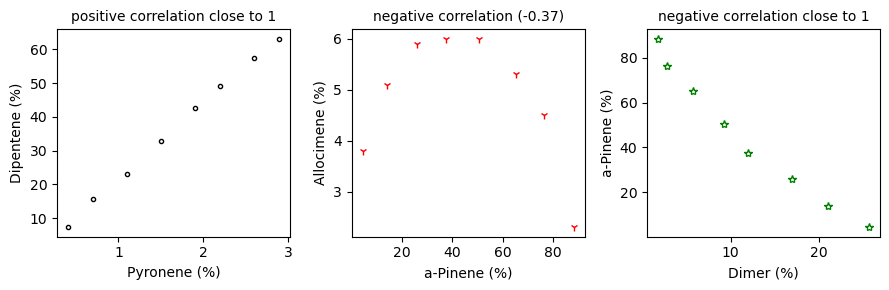

In [5]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3))

ax[0].plot(df['Pyronene (%)'], df['Dipentene (%)'],'k.', mfc = 'none')
ax[0].set_title('positive correlation close to 1', fontsize = 10)
ax[0].set_xlabel('Pyronene (%)')
ax[0].set_ylabel('Dipentene (%)')

ax[1].plot(df['a-Pinene (%)'], df['Allocimene (%)'],'r1', mfc = 'none')
ax[1].set_title('negative correlation (-0.37)', fontsize = 10)
ax[1].set_xlabel('a-Pinene (%)')
ax[1].set_ylabel('Allocimene (%)')

ax[2].plot(df['Dimer (%)'], df['a-Pinene (%)'],'g*', mfc = 'none')
ax[2].set_title('negative correlation close to 1', fontsize = 10)
ax[2].set_xlabel('Dimer (%)')
ax[2].set_ylabel('a-Pinene (%)')

fig.tight_layout()

In [6]:
# original matrix with 5 responses
y_5_responses = df.iloc[:, 1:].T.values
y_5_responses

array([[88.35, 76.4 , 65.1 , 50.4 , 37.5 , 25.9 , 14.  ,  4.5 ],
       [ 7.3 , 15.6 , 23.1 , 32.9 , 42.7 , 49.1 , 57.4 , 63.1 ],
       [ 2.3 ,  4.5 ,  5.3 ,  6.  ,  6.  ,  5.9 ,  5.1 ,  3.8 ],
       [ 1.75,  2.8 ,  5.8 ,  9.3 , 12.  , 17.  , 21.  , 25.7 ],
       [ 0.4 ,  0.7 ,  1.1 ,  1.5 ,  1.9 ,  2.2 ,  2.6 ,  2.9 ]])

In [7]:
# reduced matrix with 4 responses
y_4_responses = df.iloc[:, 1:-1].T.values
y_4_responses

array([[88.35, 76.4 , 65.1 , 50.4 , 37.5 , 25.9 , 14.  ,  4.5 ],
       [ 7.3 , 15.6 , 23.1 , 32.9 , 42.7 , 49.1 , 57.4 , 63.1 ],
       [ 2.3 ,  4.5 ,  5.3 ,  6.  ,  6.  ,  5.9 ,  5.1 ,  3.8 ],
       [ 1.75,  2.8 ,  5.8 ,  9.3 , 12.  , 17.  , 21.  , 25.7 ]])

In [8]:
# initial values for the ode_system
y_ode_init = df.iloc[0, 1:].values
y_ode_init

array([88.35,  7.3 ,  2.3 ,  1.75,  0.4 ])

In [9]:
# matrix of independent variable
t_obs = np.array([df.iloc[:, 0].T])
t_obs

array([[ 1230,  3060,  4920,  7800, 10680, 15030, 22620, 36420]])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C')

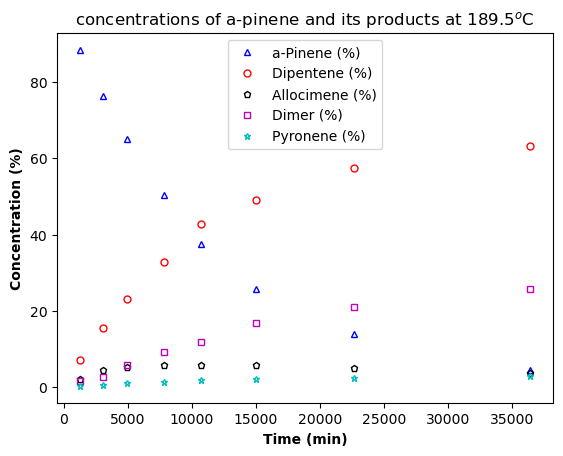

In [10]:
# plot the experimental values
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']

fig, ax = plt.subplots()

for idx, j in enumerate(df.columns[1:]):
    plt.plot(df['Time (min)'], df[j], marker = markers[idx], markersize = 5, 
             color = colors[idx], linestyle = " ", mfc = "none")
    plt.legend([col for col in df.columns[1:]])


ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C')

A linear kinetic model was proposed in Box et al. (1973) for the a-pinene data, of the form:

\begin{equation*} \frac{d \gamma_1}{dt} = -(\theta_1 + \theta_2)\gamma_1  \tag{1}\end{equation*}

\begin{equation*} \frac{d \gamma_2}{dt} = \theta_1\gamma_1  \tag{2}\end{equation*}

\begin{equation*} \frac{d \gamma_3}{dt} = \theta_2\gamma_1 - (\theta_3 + \theta_4)\gamma_3 + \theta_5\gamma_5  \tag{3}\end{equation*}

\begin{equation*} \frac{d \gamma_4}{dt} = \theta_3\gamma_3  \tag{4}\end{equation*}

\begin{equation*} \frac{d \gamma_5}{dt} = \theta_4\gamma_3 - \theta_5\gamma_5  \tag{5}\end{equation*}

In [11]:
# linear kinetic model structure
def ode_system(t, y, *p):
    
    dg1_dt = -(p[0] + p[1])*y[0]
    
    dg2_dt = p[0]*y[0]
    
    dg3_dt = p[1]*y[0] - (p[2] + p[3])*y[2] + p[4]*y[4]
    
    dg4_dt = p[2]*y[2]
    
    dg5_dt = p[3]*y[2] - p[4]*y[4]
    
    return np.hstack([dg1_dt, dg2_dt, dg3_dt, dg4_dt, dg5_dt])

# estimated rates at t = 1230 s
ode_system(1230, y_ode_init, 5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5)

array([-7.774800e-03,  5.247990e-03,  1.823791e-03,  1.041900e-05,
        6.926000e-04])

In [12]:
def regres_fun_original(t, a, b, c, d, e):
    
    sol_original = solve_ivp(ode_system, (t[0], t[-1]), y_ode_init, 
                    args = (a, b, c, d, e), t_eval = t)
    
    return sol_original.y

In [13]:
bnds = [(0, 1e-3), (0, 1e-3), (0, 1e-3), (0, 1e-3), (0, 1e-3)]

### 1st attempt using lmfit -  (5 responses)

**(lmfit)** is a high-level interface to non-linear optimization and curve fitting problems for Python. It builds on and extends many of the optimization methods of **scipy.optimize**. Initially inspired by (and named for) extending the Levenberg-Marquardt method from **scipy.optimize.leastsq**.

In [14]:
mod_original = Model(regres_fun_original)
params_original = mod_original.make_params(a=6.0e-5, b=3.0e-5, c=0.5e-5, d=30.0e-5, e=5.5e-5)

result_original = mod_original.fit(y_5_responses, params_original, t=time)

print(result_original.fit_report())

best_values_original_lmfit = np.array(list(result_original.best_values.values()))
best_fit_original_lmfit = result_original.best_fit

[[Model]]
    Model(regres_fun_original)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 40
    # variables        = 5
    chi-square         = 29.4831869
    reduced chi-square = 0.84237677
    Akaike info crit   = -2.20237157
    Bayesian info crit = 6.24202570
    R-squared          = 0.99865958
[[Variables]]
    a:  5.8886e-05 +/- 7.2299e-07 (1.23%) (init = 6e-05)
    b:  2.7837e-05 +/- 6.8523e-07 (2.46%) (init = 3e-05)
    c:  1.7446e-04 +/- 1.1518e-05 (6.60%) (init = 5e-06)
    d:  3.9778e-05 +/- 1.3932e-05 (35.02%) (init = 0.0003)
    e:  3.6523e-05 +/- 2.6954e-05 (73.80%) (init = 5.5e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = +0.8786
    C(c, d) = +0.2226
    C(b, c) = -0.1604
    C(b, d) = +0.1561
    C(a, b) = +0.1306


### 2nd attempt using (L-BFGS-B) with (min_det) loss function - (5 responses)

Limited-memory **(BFGS)** is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden-Fletcher Goldfarb Shanno algorithm (BFGS) using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. The algorithm's target problem is to minimize $f(x)$ over unconstrained values of the real-vector $x$ where $f$ is a differentiable scalar function.

In [15]:
# loss function
def min_det(p, t, y, f):
    
    y_pred = f(t, *p)
    z = y_pred - y

    return np.linalg.det(z.dot(z.T))
 
# the initial values could be adopted either from the original Bates and Watts or from the lmfit fit_report()
initial_values = best_values_original_lmfit

min_sol_original_BFGS_1 = minimize(min_det,
                            initial_values,
                            args=(t_obs[0], y_5_responses, regres_fun_original),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_original_BFGS_1

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0010093987857578645
        x: [ 6.035e-05  2.882e-05  1.431e-04  1.685e-05  1.821e-07]
      nit: 14
      jac: [ 1.234e+03 -8.678e+02  5.027e+02  6.757e+02 -6.550e+02]
     nfev: 204
     njev: 34
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 5 responses')

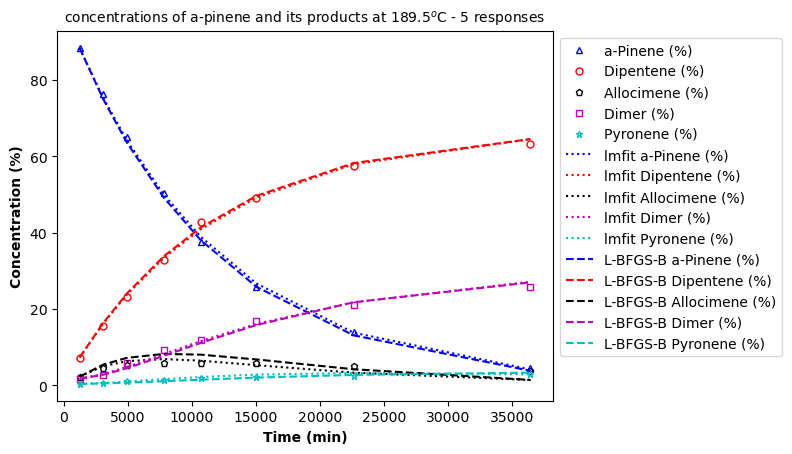

In [16]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'L-BFGS-B ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(best_fit_original_lmfit):
    
    ax.plot(time, arr, ":", color = colors[idx])    

for idx, arr in enumerate(regres_fun_original(time, *min_sol_original_BFGS_1.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 5 responses', fontsize = 10)

### Assessing the original model using (lmfit) & (L-BFGS-B) with (min_det) - (5 responses)

In [17]:
y_pred_original_lmfit = best_fit_original_lmfit
residuals_original_lmfit = y_pred_original_lmfit - df.iloc[:, 1:].T.values

y_pred_original_BFGS_1 = regres_fun_original(time, *min_sol_original_BFGS_1.x)
residuals_original_BFGS_1 = y_pred_original_BFGS_1 - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - (lmfit) \n & (L-BFGS-B) with (min_det) - (5 responses)')

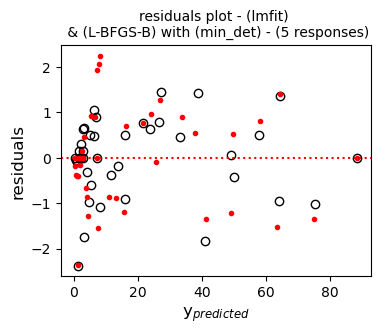

In [18]:
fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_pred_original_lmfit, residuals_original_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_original_BFGS_1, residuals_original_BFGS_1, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - (lmfit) \n & (L-BFGS-B) with (min_det) - (5 responses)', fontsize = 10)

## Observations

**(lmfit)** seems to lead to a better convergence between the observed and predicted values most likely due to the stable **least-squares** approach. On the other hand, it can be assumed by examining the plots with concentration profiles and residuals that probably the convergence of the loss function **(min_det)** with multicollinearity on the response variables seems poor. 

That said, another approach for the loss function **(min_lsq)** (i.e., **unweighted sum of squared residuals**) alongside a different scipy optimize method (i.e., **Differential Evolution**) are adopted to re-assess the fitting as demonstrated below. 

*Note that unweighted sum of squared residuals might be inadequate when response variables are in very different scales.*

### 3rd attempt using Differential Evolution (DE) with (min_lsq) loss function - (5 responses)

**Differential Evolution (DE)** is stochastic in nature (does not use gradient methods) to find the minimum, and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient-based techniques.

In [19]:
# unweighted sum of squared residuals
def min_lsq(p, t, y, f):
    
    y_pred = f(t, *p)
    z = y_pred - y

    return np.sum(z * z)

min_sol_original_DE = differential_evolution(
    min_lsq,
    bnds,
    args=(t_obs[0], y_5_responses, regres_fun_original),
    strategy="rand1bin",
    mutation=(0.3, 1.0),
    recombination=0.7,
    popsize=50,
    maxiter=100
    )

min_sol_original_DE

 message: Optimization terminated successfully.
 success: True
     fun: 29.483308834534956
       x: [ 5.888e-05  2.783e-05  1.745e-04  3.976e-05  3.653e-05]
     nit: 85
    nfev: 21728
     jac: [ 8.576e+03 -3.534e+03  2.781e+02 -1.624e+02  3.159e+02]

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 5 responses')

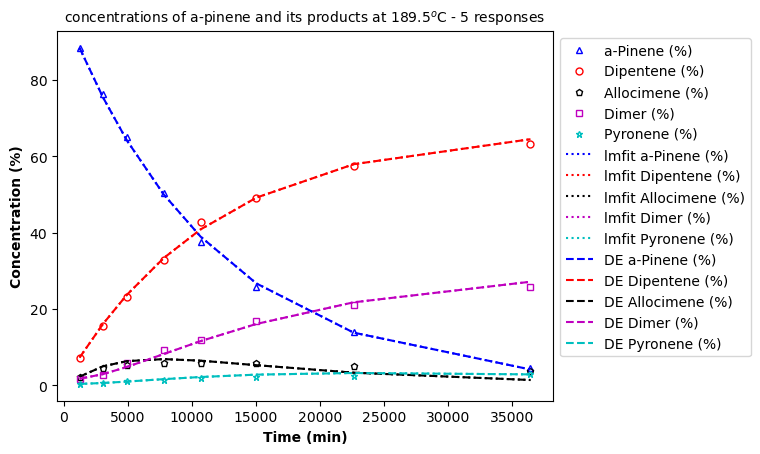

In [20]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'DE ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(best_fit_original_lmfit):
    
    ax.plot(time, arr, ":", color = colors[idx])    

for idx, arr in enumerate(regres_fun_original(time, *min_sol_original_DE.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 5 responses', fontsize = 10)

### Assessing the original model using (lmfit) & (DE) with (min_lsq) - (5 responses)

In [21]:
y_pred_original_lmfit = best_fit_original_lmfit
residuals_original_lmfit = y_pred_original_lmfit - df.iloc[:, 1:].T.values

y_pred_original_DE = regres_fun_original(time, *min_sol_original_DE.x)
residuals_original_DE = y_pred_original_DE - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - (lmfit) & (DE) \n with (min_lsq)- (5 responses)')

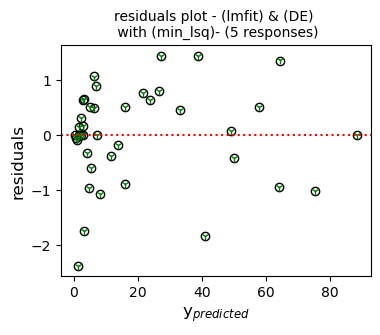

In [22]:
fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_pred_original_lmfit, residuals_original_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_original_DE, residuals_original_DE, 'g1')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - (lmfit) & (DE) \n with (min_lsq)- (5 responses)', fontsize = 10)

## Observations

Given that **(DE)** finds the global minimum of a multivariate function, converging to the same results as **(lmfit)** and **scipy's minimize** using the loss from **(min_lsq)** function is expected.

### 4rth attempt using (L-BFGS-B) with (min_lsq) loss function - (5 responses)

In [23]:
def min_lsq(p, t, y):
    
    y_pred = regres_fun_original(t, *p)
    z = y_pred - y

    return np.sum(z * z)

In [24]:
# the initial values could be adopted either from the original Bates and Watts or from the lmfit fit_report()
initial_values = [5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5]

min_sol_original_BFGS_2 = minimize(min_lsq,
                            initial_values,
                            args=(t_obs[0], y_5_responses),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_original_BFGS_2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29.48332282110733
        x: [ 5.888e-05  2.783e-05  1.745e-04  3.971e-05  3.643e-05]
      nit: 37
      jac: [ 1.167e+02  4.073e+02  1.933e-01 -5.065e+01  9.184e+00]
     nfev: 354
     njev: 59
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 5 responses')

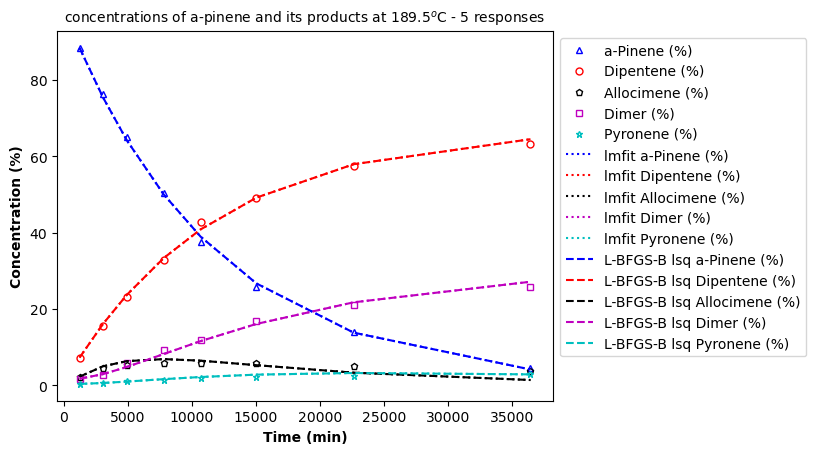

In [25]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'L-BFGS-B lsq ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(best_fit_original_lmfit):
    
    ax.plot(time, arr, ":", color = colors[idx])    

for idx, arr in enumerate(regres_fun_original(time, *min_sol_original_BFGS_2.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 5 responses', fontsize = 10)

### Assessing the original model using (lmfit) & (L-BFGS-B) with (min_lsq) - (5 responses)

In [26]:
y_pred_original_lmfit = best_fit_original_lmfit
residuals_original_lmfit = y_pred_original_lmfit - df.iloc[:, 1:].T.values

y_pred_original_BFGS_2 = regres_fun_original(time, *min_sol_original_BFGS_2.x)
residuals_original_BFGS_2 = y_pred_original_BFGS_2 - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - (lmfit) & (BFGS) \n with (min_lsq) - (5 responses)')

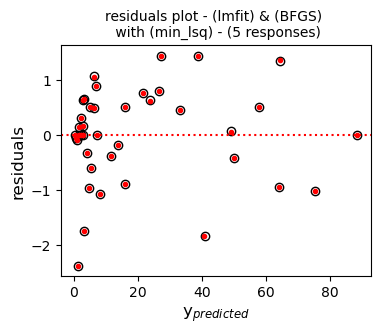

In [27]:
fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_pred_original_lmfit, residuals_original_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_original_BFGS_2, residuals_original_BFGS_2, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - (lmfit) & (BFGS) \n with (min_lsq) - (5 responses)', fontsize = 10)

### Observations

Using **(L-BFGS-B)** scipy's minimize method and a different loss function (i.e., **min_lsq**) leads to the same convergence as the one obtained from **(lmfit)** and **(DE)**.

## Conclusions - (5 responses)

After assessing the results of the Multiresponse Model with 5 responses we can see that using **(min_lsq)** loss function can lead to more accurate predictions or better convergence when evaluated against **(min_det)** loss function. Both Scipy's **(L-BFGS-B)** and **(DE)** methods as well as **(lmfit)** provide the same results. 

However, global optimizer **(DE)** is not going to be included in the reduced Multiresponse Model with 4 responses because it is time-consuming in comparison to **(L-BFGS-B)** (1/100 of computational time).

That said, the reduced Multiresponse Model with 4 responses is going to be assessed in two ways:
    
    1) (lmfit) vs (L-BFGS-B)
    2) (L-BFGS-B) with (min_det) vs (L-BFGS-B) with (min_lsq)
    
*Note that if the dependency can be explained (e.g., mass balance, or a response that has been imputed from other measured responses) and the offending responses identified, they should be removed and a multi responce analysis performed on the reduced data set*.

### 1st attempt using (lmfit) - (4 responses)

In [28]:
def regres_fun_reduced(t, a, b, c, d, e):
    
    sol_reduced = solve_ivp(ode_system, (t[0], t[-1]), y_ode_init, 
                    args = (a, b, c, d, e), t_eval = t)
    
    return sol_reduced.y[:-1]

In [29]:
mod_reduced = Model(regres_fun_reduced)
params_reduced = mod_reduced.make_params(a=6.0e-5, b=3.0e-5, c=0.5e-5, d=30.0e-5, e=5.5e-5)

result_reduced = mod_reduced.fit(y_4_responses, params_reduced, t=time)

print(result_reduced.fit_report())

best_values_reduced_lmfit = np.array(list(result_reduced.best_values.values()))
best_fit_reduced_lmfit = result_reduced.best_fit

[[Model]]
    Model(regres_fun_reduced)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 32
    # variables        = 5
    chi-square         = 26.4297014
    reduced chi-square = 0.97887783
    Akaike info crit   = 3.88008092
    Bayesian info crit = 11.2087604
    R-squared          = 0.99858049
[[Variables]]
    a:  5.8782e-05 +/- 7.8867e-07 (1.34%) (init = 6e-05)
    b:  2.8785e-05 +/- 9.4817e-07 (3.29%) (init = 3e-05)
    c:  1.7822e-04 +/- 1.3579e-05 (7.62%) (init = 5e-06)
    d:  6.7773e-05 +/- 3.0909e-05 (45.61%) (init = 0.0003)
    e:  4.8502e-05 +/- 3.8573e-05 (79.53%) (init = 5.5e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = +0.8316
    C(c, d) = +0.3308
    C(b, d) = +0.3298
    C(c, e) = +0.1225


### 2nd attempt using (L-BFGS-B) with (min_det) loss function -  (4 responses)

In [30]:
def min_det(p, t, y, f):
    
    y_pred = f(t, *p)
    z = y_pred - y

    return np.linalg.det(z.dot(z.T))

initial_values = [5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5]

min_sol_reduced_BFGS_1 = minimize(min_det,
                            initial_values,
                            args=(t_obs[0], y_4_responses, regres_fun_reduced),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_reduced_BFGS_1

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.872530633914905
        x: [ 5.885e-05  2.812e-05  1.736e-04  2.204e-05  1.840e-06]
      nit: 71
      jac: [ 6.429e+00  7.082e+01 -1.336e+01  9.799e+01 -4.257e+01]
     nfev: 684
     njev: 114
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 4 responses')

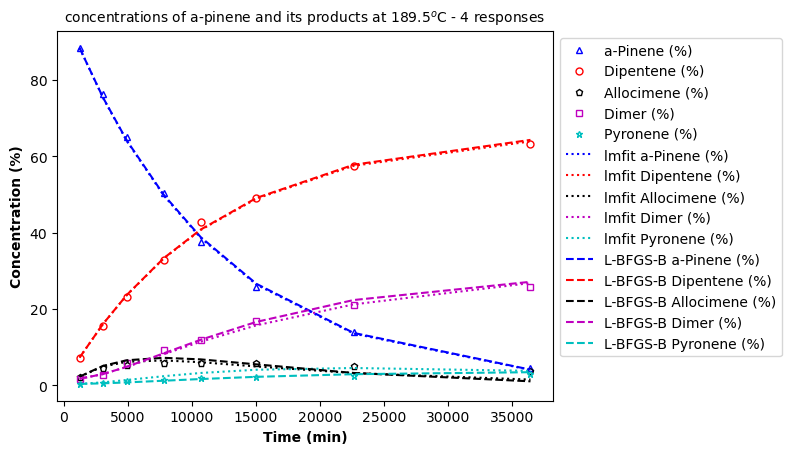

In [31]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:], 'L-BFGS-B ' + df.columns[1:]])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(regres_fun_original(time, *best_values_reduced_lmfit)):
    
    ax.plot(time, arr, ":", color = colors[idx])
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_BFGS_1.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 4 responses', fontsize = 10)

### Assessing the original model using (lmfit) & (L-BFGS-B) with (min_det) - (4 responses)

In [32]:
y_pred_reduced_lmfit = regres_fun_original(time, *best_values_reduced_lmfit)
residuals_reduced_lmfit = y_pred_reduced_lmfit - df.iloc[:, 1:].T.values

y_pred_reduced_BFGS_1 = regres_fun_original(time, *min_sol_reduced_BFGS_1.x)
residuals_reduced_BFGS_1 = y_pred_reduced_BFGS_1 - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residual plot - (lmfit) & (BFGS) \n with (min_det) - (4 responses)')

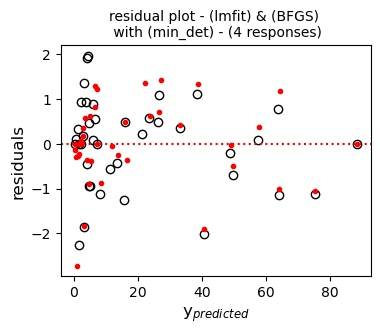

In [33]:
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(y_pred_reduced_lmfit, residuals_reduced_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_reduced_BFGS_1, residuals_reduced_BFGS_1, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residual plot - (lmfit) & (BFGS) \n with (min_det) - (4 responses)', fontsize = 10)

## Observations

Firstly it seems that **(lmfit)** optimizer performs slightly better using 5 responses instead of 4 responses as quantified by the lower values of Akaike info crit (i.e., -2.2 at 5 responses) in comparison to that of 4 responses (i.e., 3.9). 

On the other hand, the loss function **(min_det)** with multicollinearity on the response variables performs great when 4 responses (reduced) are used using **scipy (L-BFGS-B)**.

### 3rd attempt using (L-BFGS-B) with (min_lsq) loss funstion - (4 responses)

In [34]:
# unweighted sum of squared residuals
def min_lsq(p, t, y, f):
    
    y_pred = f(t, *p)
    z = y_pred - y

    return np.sum(z * z)

initial_values = [5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5]

min_sol_reduced_BFGS_2 = minimize(min_lsq,
                            initial_values,
                            args=(t_obs[0], y_4_responses, regres_fun_reduced),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_reduced_BFGS_2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 26.429850918222627
        x: [ 5.878e-05  2.878e-05  1.782e-04  6.761e-05  4.844e-05]
      nit: 36
      jac: [-6.443e+02  4.152e+03  1.001e+02 -3.113e+02  2.196e+02]
     nfev: 420
     njev: 70
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 4 responses')

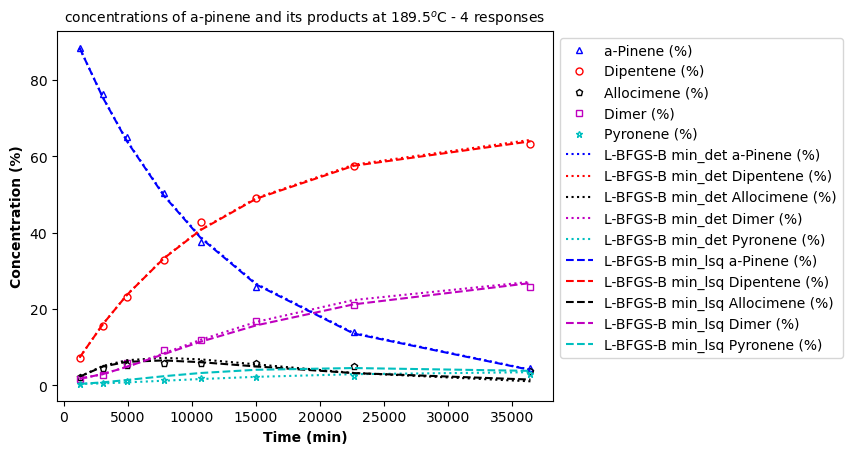

In [35]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['L-BFGS-B min_det ' + df.columns[1:], 'L-BFGS-B min_lsq ' + df.columns[1:]])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_BFGS_1.x)):
    
    ax.plot(time, arr, ":", color = colors[idx])
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_BFGS_2.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 4 responses', fontsize = 10)

### Assessing the original model using (L-BFGS-B) with (min_det) & (min_lsq) - (4 responses)

In [36]:
y_pred_reduced_BFGS_1 = regres_fun_original(time, *min_sol_reduced_BFGS_1.x)
residuals_reduced_BFGS_1 = y_pred_reduced_BFGS_1 - df.iloc[:, 1:].T.values

y_pred_reduced_BFGS_2 = regres_fun_original(time, *min_sol_reduced_BFGS_2.x)
residuals_reduced_BFGS_2 = y_pred_reduced_BFGS_2 - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - BFGS with different \n loss functions (4 responses)')

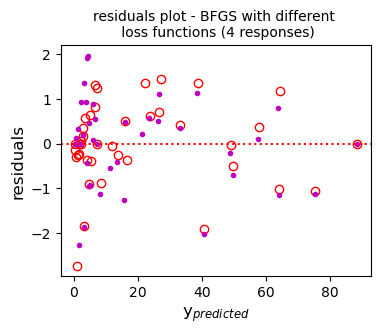

In [37]:
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(y_pred_reduced_BFGS_1, residuals_reduced_BFGS_1, 'ro', mfc = 'None')
ax.plot(y_pred_reduced_BFGS_2, residuals_reduced_BFGS_2, 'm.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - BFGS with different \n loss functions (4 responses)', fontsize = 10)

## Observations

By comparing the different loss functions one can assume that the loss function **(min_det)** with 4 response variables using **(L-BFGS-B)** provides slightly better results when compared to **(min_lsq)** loss function when **(i.e., L-BFGS-B)** method is applied.

# General Conclusions

*Both lmfit & scipy are equally efficient and can be used accordingly.*